In [13]:
import pandas as pd
from sklearn import tree, neighbors, neural_network
from sklearn import base, metrics
import numpy as np
import graphviz 
import matplotlib.pyplot as plt
from scipy import stats

In [3]:
after_match_attributes = ['home_team_goal', 'away_team_goal', 'possession_home', 'shoton_home', 'shoton_away', 
                      'shotoff_home', 'shotoff_away', 'corner_home', 'corner_away', 'cross_home', 'cross_away', 
                      'foulcommit_home', 'foulcommit_away', 'rcard_home', 'rcard_away', 'ycard_home', 'ycard_away', 
                      'throwin_home', 'throwin_away']
team_attributes = ['buildUpPlaySpeed_home', 'buildUpPlayDribbling_home', 'buildUpPlayPassing_home',
                      'buildUpPlayPositioningClass_home_isOrganised', 'chanceCreationPassing_home',
                      'chanceCreationCrossing_home', 'chanceCreationShooting_home',
                      'chanceCreationPositioningClass_home_isOrganised', 'defencePressure_home',
                      'defenceAggression_home', 'defenceTeamWidth_home', 'buildUpPlaySpeed_away',
                      'buildUpPlayDribbling_away', 'buildUpPlayPassing_away' ,
                      'buildUpPlayPositioningClass_away_isOrganised', 'chanceCreationPassing_away',
                      'chanceCreationCrossing_away', 'chanceCreationShooting_away',
                      'chanceCreationPositioningClass_away_isOrganised', 'defencePressure_away' ,
                      'defenceAggression_away', 'defenceTeamWidth_away']


def split_sets_inner(df, test):
    training = df[~df.isin(test)].dropna()
    training_args = training.drop(after_match_attributes, axis=1)
#    training_args = training.filter(team_attributes)
    test_args = test.drop(after_match_attributes, axis=1)
#    test_args = test.filter(team_attributes)
    training_answers = training['home_team_goal'] > training['away_team_goal']
    test_answers  = test['home_team_goal'] > test['away_team_goal']
    return training, training_args, training_answers, test, test_args, test_answers

def split_sets_holdout(df, frac):
    test = df.sample(frac = 1 - frac)
    return split_sets_inner(df, test)

def split_sets_kfold(df, k, n): # 0 <= n < k
    df.reindex()
    rows = df.shape[0]
    start = rows * n // k
    end = rows * (n+1) // k - 1
    test = df[start:end]
    return split_sets_inner(df, test)

df_match = pd.read_csv('../Project1/dataset.csv')
outer_train, outer_train_args, outer_train_answers, outer_test, outer_test_args, outer_test_answers = split_sets_holdout(df_match, 0.9)
print (outer_test_answers.value_counts()[0] / outer_test_answers.count())

0.594142259414


In [31]:
def do_prediction(clf, train_args, train_answers, test_args, test_answers):
    clf.fit(train_args, train_answers)
    predictions = clf.predict(test_args)
    confusion = metrics.confusion_matrix(test_answers, predictions)
    probs = clf.predict_proba(test_args)
    return (confusion[0, 0] + confusion[1, 1]) / np.sum(confusion), probs
    
def do_prediction_kfold(clf_orig, outer_train):
    folds = 10
    ret = 0
    for cur_fold in range(folds):
        clf = base.clone(clf_orig)
        train, train_args, train_answers, test, test_args, test_answers = split_sets_kfold(outer_train, folds, cur_fold)
        cur, _ = do_prediction(clf, train_args, train_answers, test_args, test_answers)
        ret = ret + cur
    return ret / folds

### Decision Tree

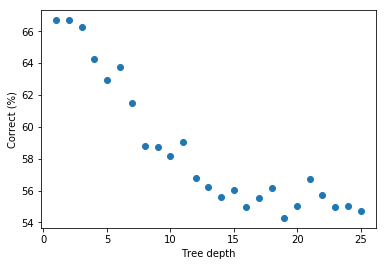

In [8]:
# Decision tree
depths_count = 25
correct_tree = np.zeros(depths_count)
depths = np.arange(1, depths_count + 1)
for i in range(depths_count):
    correct_tree[i] = do_prediction_kfold(tree.DecisionTreeClassifier(max_depth = depths[i]), outer_train)
best_depth = depths[np.argmax(correct_tree)]

plt.plot(depths, correct_tree * 100, 'o')
plt.xlabel('Tree depth')
plt.ylabel('Correct (%)')
plt.savefig('correct_tree.pdf')

In [32]:
clf_tree = tree.DecisionTreeClassifier(max_depth = best_depth)
outer_correct, tree_probs = do_prediction(clf_tree, outer_train_args, outer_train_answers, outer_test_args, outer_test_answers)
print (best_depth, correct_tree[best_depth], outer_correct)

dot_data = tree.export_graphviz(clf_tree, out_file=None, feature_names=outer_train_args.columns)
graph = graphviz.Source(dot_data)
graph.render("tree")

1 0.66691371441 0.652719665272


'tree.pdf'

### KNN

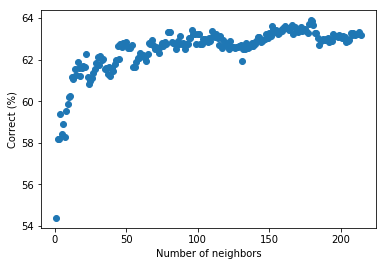

In [45]:
n_neighbors = 214
neighbors_count = np.arange(1, n_neighbors + 1)
correct_knn = np.zeros(n_neighbors)
for i in range(n_neighbors):
    correct_knn[i] = do_prediction_kfold(neighbors.KNeighborsClassifier(n_neighbors = neighbors_count[i]), outer_train)
best_k = neighbors_count[np.argmax(correct_knn)]

plt.plot(neighbors_count, correct_knn * 100, 'o')
plt.xlabel('Number of neighbors')
plt.ylabel('Correct (%)')
plt.savefig('correct_knn.pdf')

In [46]:
clf_knn = neighbors.KNeighborsClassifier(n_neighbors = best_k)
outer_correct, knn_probs = do_prediction(clf_knn, outer_train_args, outer_train_answers, outer_test_args, outer_test_answers)
print (best_k, correct_knn[best_k], outer_correct)

179 0.638480765051 0.665271966527


### ANN

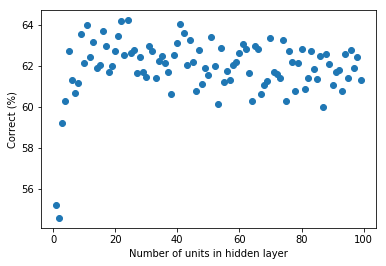

In [51]:
n_units = np.arange(1, 100, 1, dtype=int)
correct_ann = np.zeros(len(n_units))
for i in range(len(correct_ann)):
    correct_ann[i] = do_prediction_kfold(neural_network.MLPClassifier(hidden_layer_sizes = n_units[i], max_iter=1000), outer_train)
best_i = np.argmax(correct_ann)

plt.plot(n_units, correct_ann * 100, 'o')
plt.xlabel('Number of units in hidden layer')
plt.ylabel('Correct (%)')
plt.savefig('correct_ann.pdf')

In [76]:
clf_ann = neural_network.MLPClassifier(hidden_layer_sizes = n_units[best_i], max_iter=1000)
outer_correct, ann_probs = do_prediction(clf_ann, outer_train_args, outer_train_answers, outer_test_args, outer_test_answers)
print (n_units[best_i], correct_ann[best_i], outer_correct)

24 0.642242990654 0.648535564854


### t-test

In [72]:
prob_a = tree_probs[:, 1]
prob_b = knn_probs[:, 1]
tval, pval = stats.ttest_rel(prob_a, prob_b)
print (tval, pval)

-0.36364416854 0.716446550206


In [81]:
predict_a = np.where(prob_a >= 0.5, 1, 0)
predict_b = np.where(prob_b >= 0.5, 1, 0)
tval, pval = stats.ttest_rel(predict_a, predict_b)
print (tval, pval)

5.31119106644 2.49857900334e-07


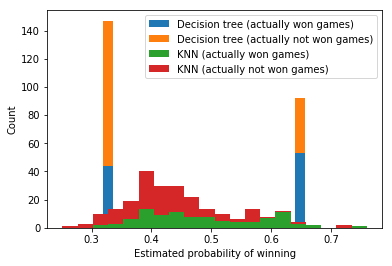

In [78]:
a_win_win  = prob_a[outer_test_answers.as_matrix()]
a_win_loss = prob_a[np.where(outer_test_answers.as_matrix(), False, True)]
b_win_win  = prob_b[outer_test_answers.as_matrix()]
b_win_loss = prob_b[np.where(outer_test_answers.as_matrix(), False, True)]
plt.hist((a_win_win, a_win_loss), stacked=True, bins = 20, label=['Decision tree (actually won games)', 'Decision tree (actually not won games)'])
plt.hist((b_win_win, b_win_loss), stacked=True, bins = 20, label=['KNN (actually won games)', 'KNN (actually not won games)'])
plt.legend()
plt.xlabel('Estimated probability of winning')
plt.ylabel('Count')
plt.savefig('class_compare.pdf')